Let us solve a very simple example $F=0 \rightarrow F=1$

In [1]:
from sympy import symbols, init_printing, Integer, zeros, Matrix, IndexedBase

import numpy as np

from fast import (State, split_hyperfine_to_magnetic, matrix_element,
                  helicity_to_cartesian, delta_greater, delta_lesser,
                  cartesian_dot_product, define_laser_variables,
                  electric_field_amplitude_intensity, polarization_vector,
                  vapour_number_density, Transition, define_density_matrix,
                  draw_lasers_3d, PlaneWave)

from fast.bloch import fast_sweep_steady_state, phase_transformation, Unfolding, electric_succeptibility, observable
from fast.symbolic import Vector3D
from matplotlib import pyplot as plt

%matplotlib inline
init_printing()

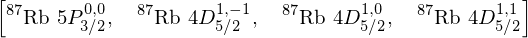

In [2]:
g = State("Rb", 87, 5, 1, 3/Integer(2), 0)
e = State("Rb", 87, 4, 2, 5/Integer(2), 1)

magnetic_states = split_hyperfine_to_magnetic([g, e])
Ne = len(magnetic_states)
magnetic_states

In [3]:
from scipy.constants import hbar, e, epsilon_0
from scipy.constants import physical_constants
a0 = physical_constants["Bohr radius"][0]
r0 = symbols("r0", positive=True)
r0 = 4.4*a0
r0

In [4]:
II = 3/Integer(2)

r = [zeros(Ne, Ne) for i in range(3)]
for q in [-1, 0, 1]:
    for i, ei in enumerate(magnetic_states):
        ji, fi, mi = ei.quantum_numbers[-3:]
        for j, ej in enumerate(magnetic_states):
            jj, fj, mj = ej.quantum_numbers[-3:]
            
            rqij = matrix_element(ji, fi, mi, jj, fj, mj, q, II, r0, numeric=False)
            if ji == jj:
                rqij = 0
            elif ji < jj:
                rqij = matrix_element(ji, fi, mi, jj, fj, mj, q, II, r0, numeric=False)
            else:
                rqij = matrix_element(ji, fi, mi, jj, fj, mj, q, II, -r0, numeric=False)
                
            r[q+1][i,j] = rqij

r_helicity = r
r = helicity_to_cartesian(r)

rp = [np.array([[complex(r[p][i,j]*delta_lesser(i,  j)) for j in range(Ne)]for i in range(Ne)]) for p in range(3)]
rm = [np.array([[complex(r[p][i,j]*delta_greater(i, j)) for j in range(Ne)]for i in range(Ne)]) for p in range(3)]

In [5]:
Nl = 1
Ep = [electric_field_amplitude_intensity(4, units="SI", Omega=1)]
Ep_symb, _ = define_laser_variables(Nl)
epsilonp_symb = Vector3D(IndexedBase("epsilonp", shape=(Nl,)))

gamma21 = 2*np.pi*6.065e6
gamma = np.zeros((Ne, Ne))
gamma[1, 0] = gamma21
gamma[2, 0] = gamma21
gamma[3, 0] = gamma21

gamma += -gamma.transpose()

omega0 = magnetic_states[0].omega
omega_level = [ei.omega -omega0 for ei in magnetic_states]

xi = np.zeros((Nl, Ne, Ne))
xi[0, 1, 0] = 1
xi[0, 2, 0] = 1
xi[0, 3, 0] = 1
xi[0, :, :] += xi[0, :, :].transpose()

theta = phase_transformation(Ne, Nl, rm, xi)

In [6]:
sweep_steady_state = fast_sweep_steady_state(Ep_symb, epsilonp_symb, gamma, omega_level, rm, xi, theta)

In [7]:
epsilonpp = polarization_vector(0, 0, 0, np.pi/8, 1, numeric=True)
epsilonpp = np.array([epsilonpp])

epsilonpm = polarization_vector(0, 0, 0, -np.pi/8, 1, numeric=True)
epsilonpm = np.array([epsilonpm])

print epsilonpp
print epsilonpm

[[ 0.70710678+0.j          0.00000000+0.70710678j  0.00000000+0.j        ]]
[[ 0.70710678+0.j          0.00000000-0.70710678j  0.00000000+0.j        ]]


In [8]:
epsilonpx = np.array([[1, 0, 0]])
epsilonpy = np.array([[0, 1, 0]])

print epsilonpx
print epsilonpy

[[1 0 0]]
[[0 1 0]]


In [9]:
unfolding = Unfolding(Ne, True, True, True)
Mu = unfolding.Mu

In [10]:
delta0 = -2*np.pi*80e6
deltaf = +2*np.pi*80e6
Ndelta = 401

deltas, rho = sweep_steady_state(Ep, epsilonpp, [[delta0, deltaf, Ndelta]])

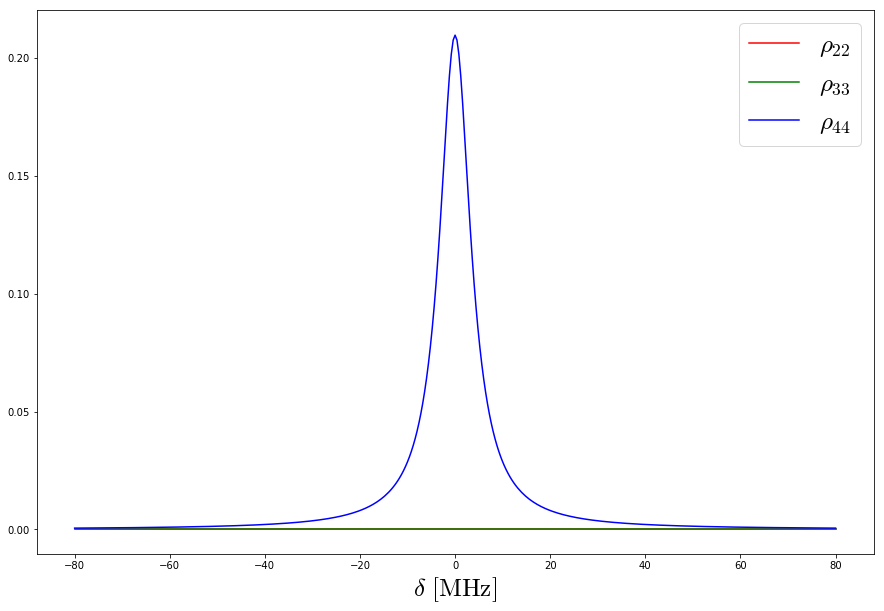

In [11]:
rho22 = rho[:, Mu(1, 1, 1)]
rho33 = rho[:, Mu(1, 2, 2)]
rho44 = rho[:, Mu(1, 3, 3)]

plt.figure(figsize=(15, 10))
plt.plot(deltas/2/np.pi*1e-6, rho22, "r-", label= r"$\rho_{22}$")
plt.plot(deltas/2/np.pi*1e-6, rho33, "g-", label= r"$\rho_{33}$")
plt.plot(deltas/2/np.pi*1e-6, rho44, "b-", label= r"$\rho_{44}$")
plt.xlabel(r"$\delta \ \mathrm{[MHz]}$", fontsize=25)
plt.legend(fontsize=25)

In [12]:
n = vapour_number_density(273.15+20, "Rb")
n

In [13]:
chirep = electric_succeptibility(0, Ep, epsilonpp, rm, n, rho, unfolding, +1)
chiimp = electric_succeptibility(0, Ep, epsilonpp, rm, n, rho, unfolding, -1)

chirem = electric_succeptibility(0, Ep, epsilonpm, rm, n, rho, unfolding, +1)
chiimm = electric_succeptibility(0, Ep, epsilonpm, rm, n, rho, unfolding, -1)

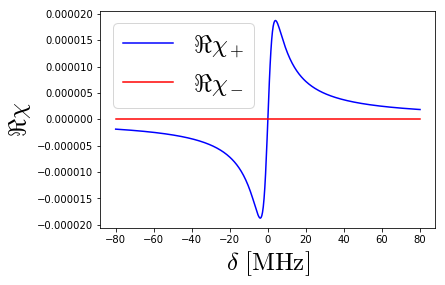

In [14]:
plt.plot(deltas/2/np.pi*1e-6, chirep, "b-", label=r"$\Re \chi_+$")
plt.plot(deltas/2/np.pi*1e-6, chirem, "r-", label=r"$\Re \chi_-$")

plt.ylabel(r"$\Re \chi$", fontsize=25)
plt.xlabel(r"$\delta \ \mathrm{[MHz]}$", fontsize=25)
plt.legend(fontsize=25)

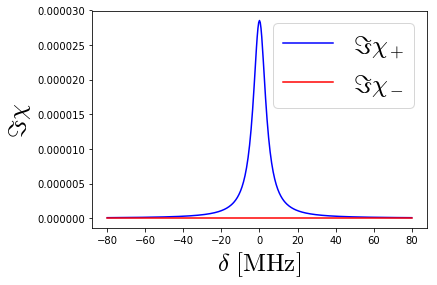

In [15]:
plt.plot(deltas/2/np.pi*1e-6, chiimp, "b-", label=r"$\Im \chi_+$")
plt.plot(deltas/2/np.pi*1e-6, chiimm, "r-", label=r"$\Im \chi_-$")

plt.ylabel(r"$\Im \chi$", fontsize=25)
plt.xlabel(r"$\delta \ \mathrm{[MHz]}$", fontsize=25)
plt.legend(fontsize=25)

In [16]:
k = Transition(magnetic_states[3], magnetic_states[0]).wavenumber

alphap = 2*k * np.imag(np.sqrt(1+1j*chiimp))
alpham = 2*k * np.imag(np.sqrt(1+1j*chiimm))

kp = k*np.sqrt(1+chirep)
km = k*np.sqrt(1+chirem)

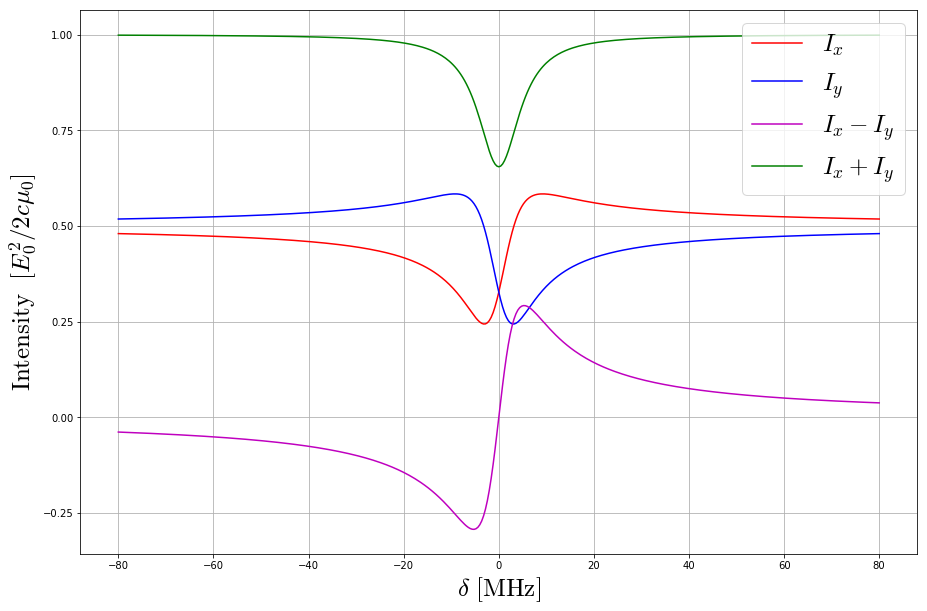

In [17]:
phi = -np.pi/4
L = 0.01
Ix = (np.exp(-L*alpham)+np.exp(-L*alphap))/4 + np.exp(-L*(alphap+alpham)/2)*np.cos(L*(kp-km)+2*phi)/2
Iy = (np.exp(-L*alpham)+np.exp(-L*alphap))/4 - np.exp(-L*(alphap+alpham)/2)*np.cos(L*(kp-km)+2*phi)/2

plt.figure(figsize=(15, 10))
plt.axes().set_yticks([-0.25, 0, 0.25, 0.5, 0.75, 1])

plt.plot(deltas/2/np.pi*1e-6, Ix, "r-", label=r"$I_x$")
plt.plot(deltas/2/np.pi*1e-6, Iy, "b-", label=r"$I_y$")
plt.plot(deltas/2/np.pi*1e-6, Ix-Iy, "m-", label=r"$I_x-I_y$")
plt.plot(deltas/2/np.pi*1e-6, Ix+Iy, "g-", label=r"$I_x+I_y$")

plt.xlabel(r"$\delta \ \mathrm{[MHz]}$", fontsize=25)
plt.ylabel(r"$\mathrm{Intensity} \ \ [E_0^2/2c\mu_0]$", fontsize=25)
plt.grid(True)
plt.legend(fontsize=25, loc=1)

A representation of the pump and probe beams

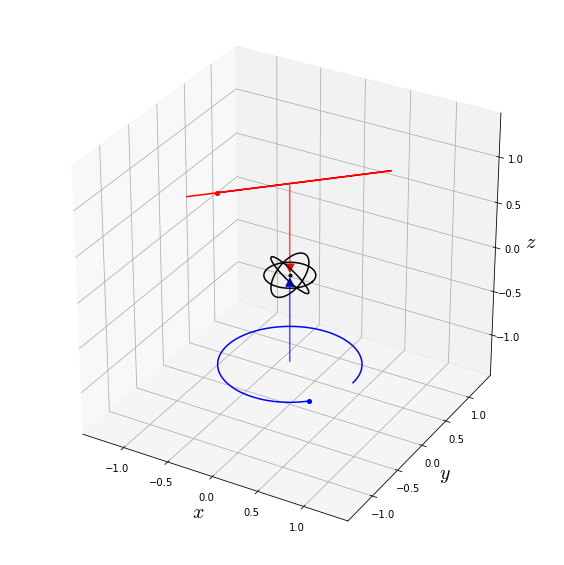

In [18]:
l_pump = PlaneWave(0, 0, 0, np.pi/8)
l_prob = PlaneWave(0, np.pi, -np.pi/8, 0, color="red")

fig = plt.figure(figsize=(10, 10)); ax = fig.gca(projection='3d')
draw_lasers_3d(ax,[l_pump, l_prob], '_lasers.png')

# Symbolic formulas for birefringence curves

In [19]:
from sympy import symbols, I, exp, re, im, sin, cos, simplify, pi
phi, alphap, alpham, kp, km, L = symbols("phi alpha_+ alpha_- k_+ k_- L", real=True)
phi, alphap, alpham, kp, km, L

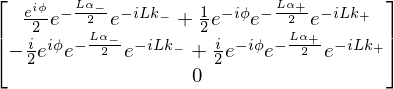

In [20]:
vsp = Matrix([1, I, 0])
vsm = Matrix([1, -I, 0])
E  = vsp * exp(-alphap*L/2) * exp(-I*phi)/2 * exp(- I*kp*L) 
E += vsm * exp(-alpham*L/2) * exp(+I*phi)/2 * exp(- I*km*L) 

E

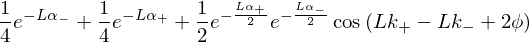

In [21]:
Ix = E[0]*E[0].conjugate()
Ix = simplify(re(Ix))
Ix

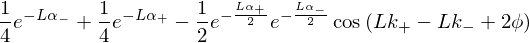

In [22]:
Iy = E[1]*E[1].conjugate()
Iy = simplify(re(Iy))
Iy

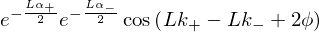

In [23]:
sig = Ix - Iy
sig

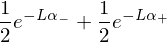

In [24]:
sigsum = Ix + Iy
sigsum